In [ ]:
! pip install linearmodels

In [ ]:
import warnings
import numpy as np
import pandas as pd
from pandas_datareader import wb
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import chi2

from linearmodels import RandomEffects
from linearmodels.panel import PanelOLS, PooledOLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.outliers_influence as oi
from statsmodels.iolib.summary2 import summary_col

**Эконометрическое моделирование экономического роста стран Евросоюза с использованием панельных данных**

Экономический рост является одной из ключевых целей экономической политики всех стран, включая государства Европейского Союза (ЕС). Стремление к устойчивому и долгосрочному экономическому росту требует глубокого понимания факторов, влияющих на его динамику. В этом контексте эконометрическое моделирование становится важным инструментом для анализа и прогнозирования экономических процессов. Использование панельных данных, которые представляют собой многомерные временные ряды, позволяет исследовать экономический рост с учетом как временных, так и межстрановых различий.

Актуальность исследования обусловлена необходимостью понимания механизмов экономического роста и его стимулирования для обеспечения устойчивого развития стран Евросоюза. Экономический рост является важным фактором для повышения уровня жизни населения, создания новых рабочих мест, развития инфраструктуры и обеспечения финансовой стабильности. Поэтому изучение факторов, способствующих экономическому росту, имеет высокую актуальность для государственных и частных организаций, занимающихся разработкой экономической политики и инвестиционными решениями.

Целью данного исследования - определить основные факторы, влияющие на экономический рост стран Евросоюза, используя эконометрическое моделирование на основе панельных данных.

Для проведения исследования будут использованы панельные данные, включающие информацию о следующих странах Евросоюза:  Германия, Франция, Италия, Испания, Польша, Румыния, Бельгия, Греция, Хорватия, Чехия и Португалия. Данные будут собраны за период с 2017 по 2021 год из базы данных World Bank (Всемирный банк).

Для проведения анализа будем использовать следующие показатели:

1. Темп роста ВВП на душу населения: Скорость, с которой реальный доход на душу населения страны увеличивается каждый год.

2. Инвестиции в исследования и развитие: Процент от общей экономики, который страна вкладывает в новые идеи и технологии для улучшения своего развития.

3. Уровень инфляции: Годовой процентный прирост цен на товары и услуги, который влияет на покупательную способность денег.

4. Количество иностранных прямых инвестиций (FDI): Процент от общей экономики, вложенный иностранными компаниями в страну для развития бизнеса.

5. Занятость: Процент экономически активного населения, занятого в экономике.

6. Уровень образования: Процент людей, получающих высшее образование из числа тех, кто может это сделать.

Эти переменные представляют собой ключевые аспекты экономического развития и состояния страны, и анализ этих показателей может дать представление о ее общем экономическом положении.

In [ ]:
unit_names = ['Germany', 'France', 'Italy', 'Spain', 'Poland', 'Romania', 'Belgium', 'Greece', 'Czech Republic', 'Portugal', 'Croatia']
country_code = ['DE', 'FR', 'IT', 'ES', 'PL', 'RO', 'BE', 'GR', 'CZ', 'PT', 'HR']

start_date = datetime(2011, 1, 1)
end_date = datetime(2021, 1, 1)

indicator_code = ["NY.GDP.PCAP.KD.ZG", "GB.XPD.RSDV.GD.ZS", "FP.CPI.TOTL.ZG", "BX.KLT.DINV.WD.GD.ZS", "SL.EMP.TOTL.SP.ZS", "SE.TER.ENRR"]

df_panel = wb.download(indicator=indicator_code, country=country_code, start=start_date, end=end_date)

df_panel = df_panel.rename(columns={
    'NY.GDP.PCAP.KD.ZG': 'Темп роста ВВП на душу населения',
    'GB.XPD.RSDV.GD.ZS': 'Инвестиции в исследования и развитие',
    'FP.CPI.TOTL.ZG': 'Уровень инфляции',
    'BX.KLT.DINV.WD.GD.ZS': 'Количество иностранных прямых инвестиций (FDI)',
    'SL.EMP.TOTL.SP.ZS': 'Занятость',
    'SE.TER.ENRR': 'Уровень образования'
})

df_panel = df_panel.rename(index=dict(zip(df_panel.index.levels[0], unit_names)), level=0)
df_panel.index = df_panel.index.set_names(['COUNTRY', 'YEAR'], level=[0, 1])
df_panel = df_panel.sort_index(level=['COUNTRY', 'YEAR'])
df_panel = df_panel.set_index(df_panel.index.set_levels(df_panel.index.levels[1].astype(int), level=1))
df_panel.head(3)

Темп роста ВВП на душу населения  \
COUNTRY YEAR                                     
Belgium 2011                          0.534287   
        2012                         -3.242060   
        2013                         -2.972404   

              Инвестиции в исследования и развитие  Уровень инфляции  \
COUNTRY YEAR                                                           
Belgium 2011                               1.20155          2.780633   
        2012                               1.26219          3.041363   
        2013                               1.30107          1.219993   

              Количество иностранных прямых инвестиций (FDI)  Занятость  \
COUNTRY YEAR                                                              
Belgium 2011                                        1.501768     44.115   
        2012                                        0.001672     43.853   
        2013                                        0.911863     42.862   

              Уровень образования  
COUNTRY YEAR                       
Belgium 2011            64.248833  
        2012            62.344070  
        2013            60.891750

**Анализ данных**

Все данные уже приведены к одной и той же шкале измерения, так как измеряются в процентах.

In [ ]:
df_panel.isna().sum()

Темп роста ВВП на душу населения                  0
Инвестиции в исследования и развитие              0
Уровень инфляции                                  0
Количество иностранных прямых инвестиций (FDI)    0
Занятость                                         0
dtype: int64

Пропущенных значений нет.

In [ ]:
x = df_panel.drop(columns='Темп роста ВВП на душу населения')
y = df_panel['Темп роста ВВП на душу населения']

**Построение моделей**

**Модель Пула**

В этой моделе все индивидуальные эффекты полностью игнорируются.

In [ ]:
exog = sm.add_constant(x)
pooledOLS = PanelOLS(y, exog, entity_effects=False, time_effects=False)
pooledOLS = pooledOLS.fit()
print(pooledOLS)

                                 PanelOLS Estimation Summary                                  
Dep. Variable:     Темп роста ВВП на душу населения   R-squared:                        0.3767
Estimator:                                 PanelOLS   R-squared (Between):              0.3096
No. Observations:                                55   R-squared (Within):               0.3836
Date:                              Wed, Jun 05 2024   R-squared (Overall):              0.3767
Time:                                      12:42:45   Log-likelihood                   -157.31
Cov. Estimator:                          Unadjusted                                           
                                                      F-statistic:                      5.9232
Entities:                                        11   P-value                           0.0002
Avg Obs:                                     5.0000   Distribution:                    F(5,49)
Min Obs:                                     5.000

Константа, Инвестиции в исследования и развитие, Занятость и Уровень образования незначимы (P-value > 0.05).

Проведем пошаговый отбор признаков, чтобы построить итоговую модель.

Сначала удалим наименее значимый признак Уровень образования (наибольшее p-значение).

In [ ]:
exog = sm.add_constant(x[['Инвестиции в исследования и развитие', 'Уровень инфляции', 'Занятость', 'Количество иностранных прямых инвестиций (FDI)']])
pooledOLS = PanelOLS(y, exog, entity_effects=False, time_effects=False)
pooledOLS = pooledOLS.fit()
print(pooledOLS)

                                 PanelOLS Estimation Summary                                  
Dep. Variable:     Темп роста ВВП на душу населения   R-squared:                        0.3767
Estimator:                                 PanelOLS   R-squared (Between):              0.3005
No. Observations:                                55   R-squared (Within):               0.3844
Date:                              Wed, Jun 05 2024   R-squared (Overall):              0.3767
Time:                                      12:42:45   Log-likelihood                   -157.31
Cov. Estimator:                          Unadjusted                                           
                                                      F-statistic:                      7.5531
Entities:                                        11   P-value                           0.0001
Avg Obs:                                     5.0000   Distribution:                    F(4,50)
Min Obs:                                     5.000

Далее удалим константу.

In [ ]:
exog = x[['Инвестиции в исследования и развитие', 'Уровень инфляции', 'Занятость', 'Количество иностранных прямых инвестиций (FDI)']]
pooledOLS = PanelOLS(y, exog, entity_effects=False, time_effects=False)
pooledOLS = pooledOLS.fit()
print(pooledOLS)

                                 PanelOLS Estimation Summary                                  
Dep. Variable:     Темп роста ВВП на душу населения   R-squared:                        0.4180
Estimator:                                 PanelOLS   R-squared (Between):              0.5662
No. Observations:                                55   R-squared (Within):               0.3817
Date:                              Wed, Jun 05 2024   R-squared (Overall):              0.4180
Time:                                      12:42:45   Log-likelihood                   -158.78
Cov. Estimator:                          Unadjusted                                           
                                                      F-statistic:                      9.1568
Entities:                                        11   P-value                           0.0000
Avg Obs:                                     5.0000   Distribution:                    F(4,51)
Min Obs:                                     5.000

Удалим признак Инвестиции в исследования и развитие.

In [ ]:
exog = x[['Уровень инфляции', 'Занятость', 'Количество иностранных прямых инвестиций (FDI)']]
pooledOLS = PanelOLS(y, exog, entity_effects=False, time_effects=False)
pooledOLS = pooledOLS.fit()
print(pooledOLS)

                                 PanelOLS Estimation Summary                                  
Dep. Variable:     Темп роста ВВП на душу населения   R-squared:                        0.4179
Estimator:                                 PanelOLS   R-squared (Between):              0.5674
No. Observations:                                55   R-squared (Within):               0.3813
Date:                              Wed, Jun 05 2024   R-squared (Overall):              0.4179
Time:                                      12:42:45   Log-likelihood                   -158.78
Cov. Estimator:                          Unadjusted                                           
                                                      F-statistic:                      12.446
Entities:                                        11   P-value                           0.0000
Avg Obs:                                     5.0000   Distribution:                    F(3,52)
Min Obs:                                     5.000

Теперь все признаки значимы, так как P-value < 0.05.

Итоговый вид модели:

Y^ = 2.1395 * 'Уровень инфляции' - 0.0560 * 'Занятость' + 0.4724 * 'Количество иностранных прямых инвестиций'

        (0.496)                         (0.022)                 (0.225)

Регрессия в целом значима (P-value для F-распредления < 0.05).

Общий коэффициент детерминации (R-squared) составляет 0.4179. Этот показатель указывает на то, что модель объясняет примерно 41.79% вариации зависимой переменной (изменение ВВП в процентах).

Коэффициент детерминации межиндивидуальной вариации (R-squared (Between)) составляет 0.5674. Это означает, что модель хорошо объясняет различия между индивидуальными единицами (различия между странами).

Коэффициент детерминации внутрииндивидуальной вариации (R-squared (Within)) составляет 0.3813. Это указывает на то, что модель объясняет лишь небольшую часть вариации, которая происходит внутри каждой индивидуальной единицы (внутри страны).

Общий коэффициент детерминации (R-squared (Overall)) равен 0.4179, что соответствует общей объяснительной силе модели. Он является суммой коэффициентов детерминации внутрииндивидуальной и межиндивидуальной вариации.

Исходя из этих данных, можно сделать вывод, что модель хорошо справляется с объяснением межиндивидуальных различий, но менее успешна в объяснении вариации внутри индивидуальных единиц.

Сравним реальные данных и прогнозируемые для каждой страны.

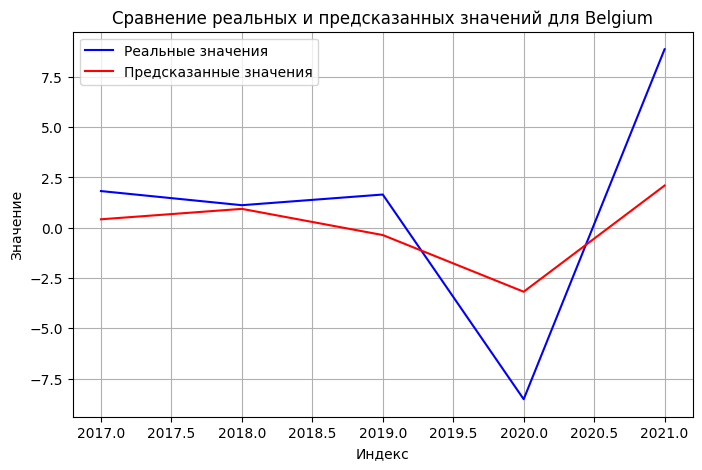

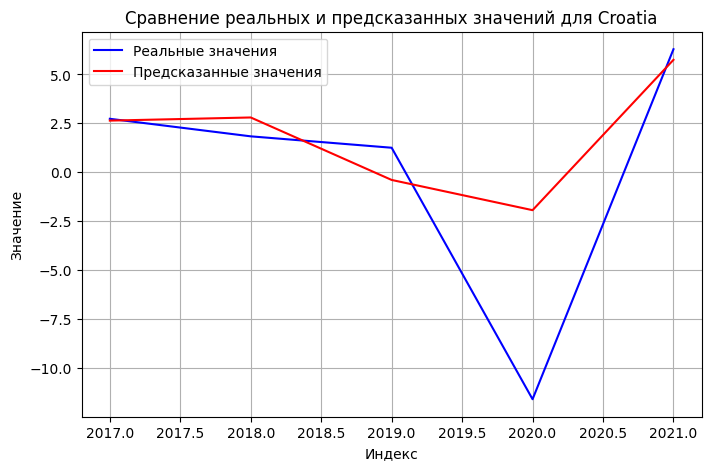

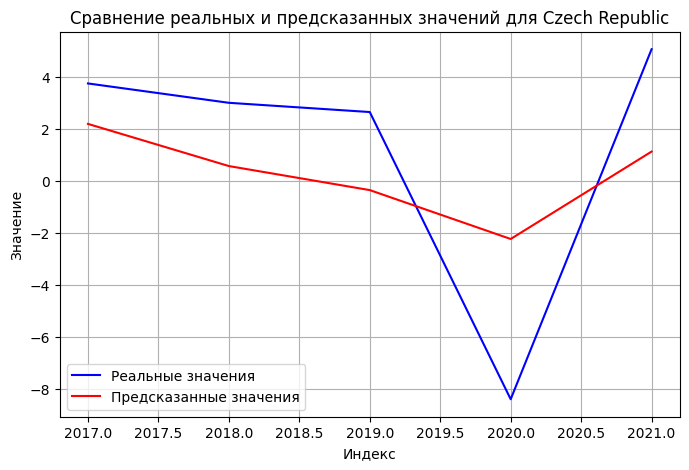

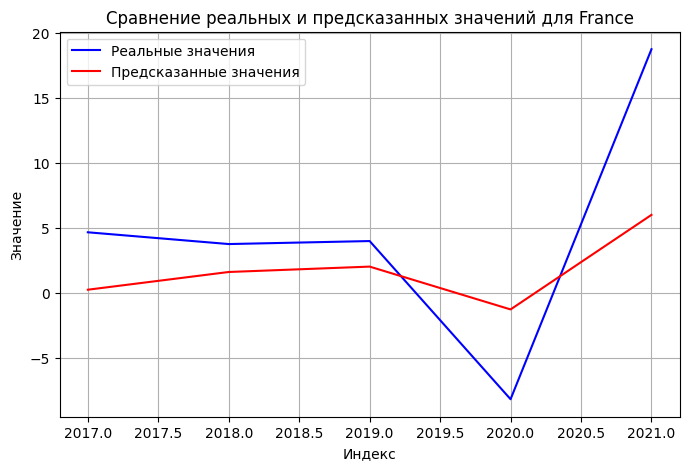

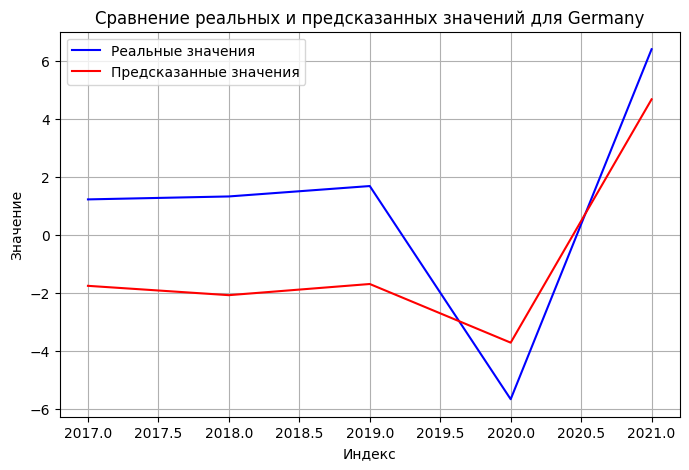

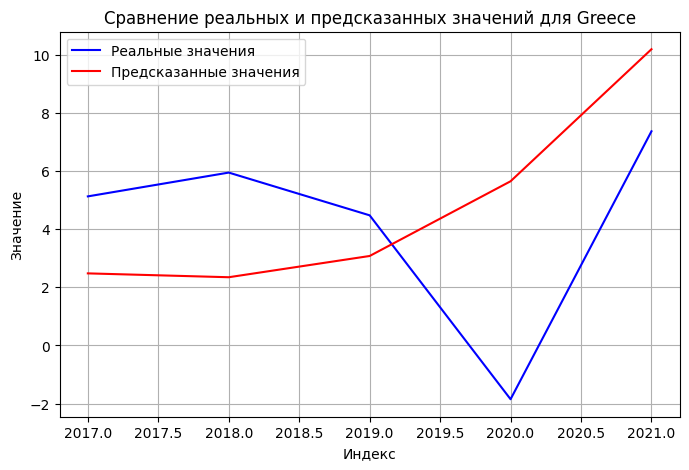

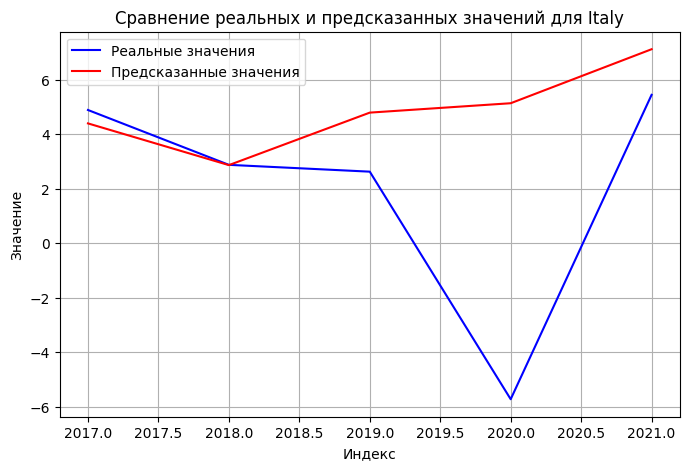

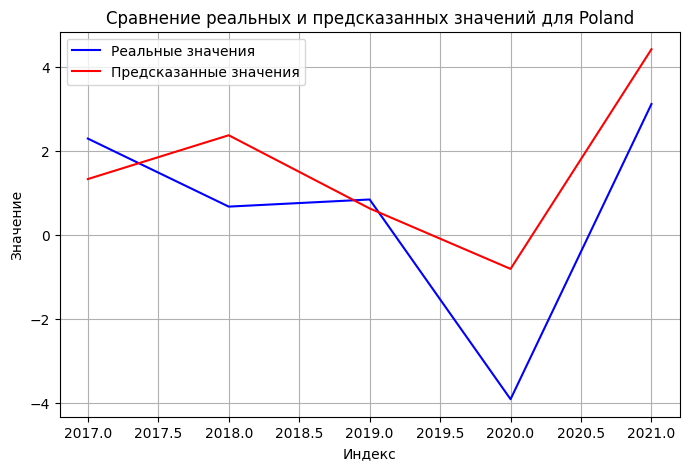

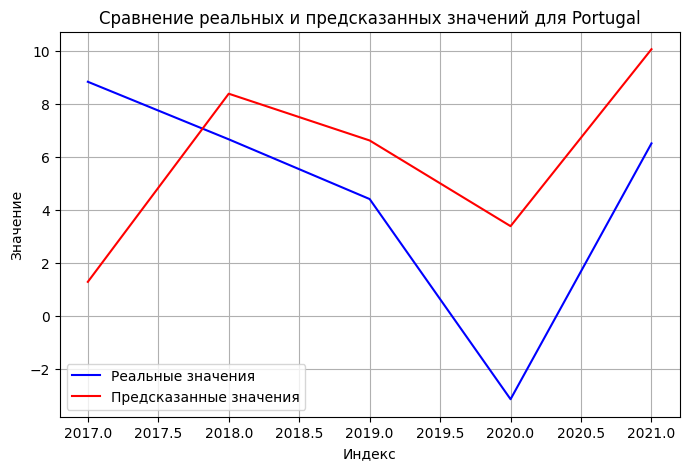

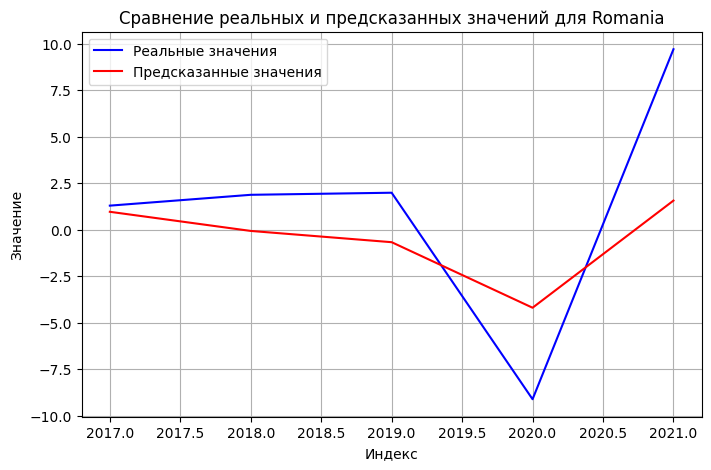

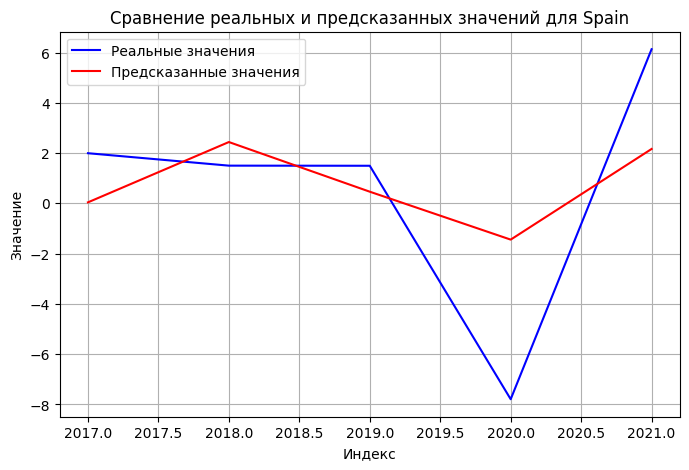

In [ ]:
predicted_values = pooledOLS.predict()

for country in predicted_values.index.levels[0]:
    real_values = y.loc[country]
    predicted_values_country = predicted_values.loc[country]

    plt.figure(figsize=(8, 5))
    plt.plot(real_values.index, real_values.values, label='Реальные значения', color='blue')
    plt.plot(real_values.index, predicted_values_country.values, label='Предсказанные значения', color='red')
    plt.title(f'Сравнение реальных и предсказанных значений для {country}')
    plt.xlabel('Индекс')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.show()

Модель неточно описывает зависимую переменную для каждой страны. Построим другие модели.

**Модель с фиксированными эффектами**

**Модель LSDV (Модель с дамма-переменными)**

In [ ]:
dummies = pd.get_dummies(df_panel.index.levels[0], prefix='COUNTRY')
dummies = dummies.reindex(dummies.index.repeat(df_panel.index.levels[1].shape[0]))
dummies.index = df_panel.index

df_panel_with_dummies = pd.concat([df_panel, dummies], axis=1)

for col in dummies.columns:
    df_panel_with_dummies[col] = df_panel_with_dummies[col].astype(int)

exog = sm.add_constant(df_panel_with_dummies.drop(columns=['Темп роста ВВП на душу населения']))
fixed_model = sm.OLS(df_panel_with_dummies['Темп роста ВВП на душу населения'], exog)
fixed_model_fitted = fixed_model.fit(use_lsdv=True)
print(fixed_model_fitted.summary())

                                   OLS Regression Results                                   
Dep. Variable:     Темп роста ВВП на душу населения   R-squared:                       0.648
Model:                                          OLS   Adj. R-squared:                  0.513
Method:                               Least Squares   F-statistic:                     4.797
Date:                              Wed, 05 Jun 2024   Prob (F-statistic):           4.00e-05
Time:                                      12:43:24   Log-Likelihood:                -141.56
No. Observations:                                55   AIC:                             315.1
Df Residuals:                                    39   BIC:                             347.2
Df Model:                                        15                                         
Covariance Type:                          nonrobust                                         
                                                     coef    std err  

Y^ = -80.8021 - 19.4099 * 'Инвестиции в исследования и развитие' + 2.5304 * 'Уровень инфляции' + 1.2773 * 'Количество иностранных прямых инвестиций (FDI)' + 1.5447 * 'Занятость' + 0.4807 * 'Уровень образования' + 5.6927 * COUNTRY_Belgium - 20.4304 * COUNTRY_Croatia - 12.0684 * COUNTRY_Czech - 7.6048 * COUNTRY_France + 25.3283 * COUNTRY_Germany - 21.0726 * COUNTRY_Greece - 15.6797 * COUNTRY_Italy + 8.3570 * COUNTRY_Poland - 22.8429 * COUNTRY_Portugal - 28.5483 * COUNTRY_Romania + 8.0669 * COUNTRY_Spain

Нулевая гипотеза LSDV заключается в том, что все фиктивные параметры,
кроме одного, равны нулю. В нашем случае, нулевая гипотеза отвергается, мы можем сказать, что модель с фиксированным эффектом лучше, чем объединенная модель OLS.

Коэффициент детерминации (R-squared) и
скорректированный коэффициент детерминации (Adj. R-squared) выше, чем у модели Пула, что может говорить о лучшем качестве модели с фиксированными эффектами.


Сравним реальные данных и прогнозируемые для каждой страны.

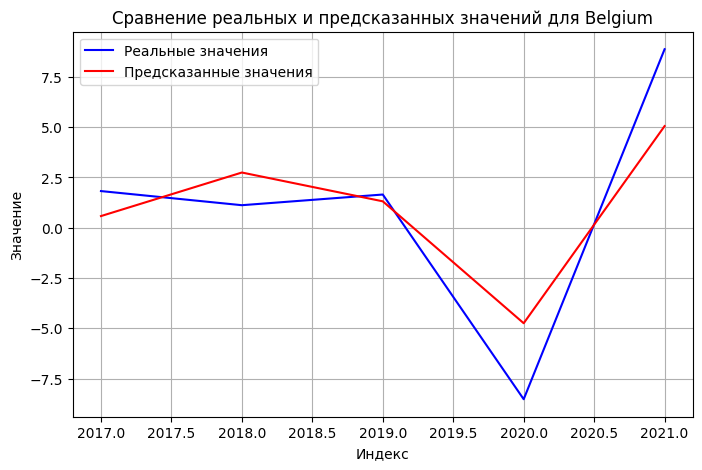

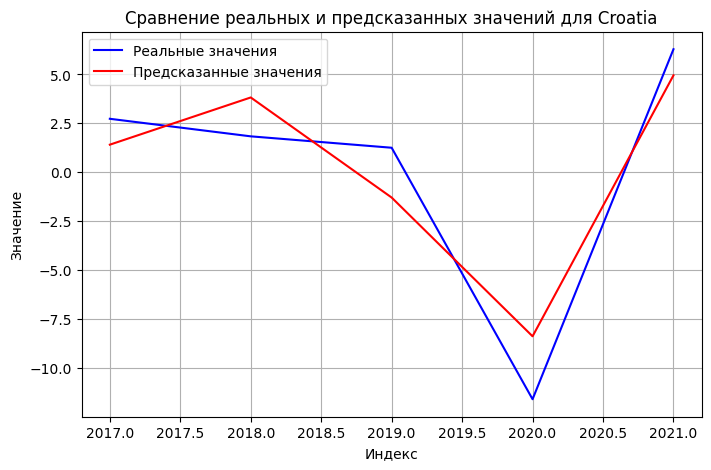

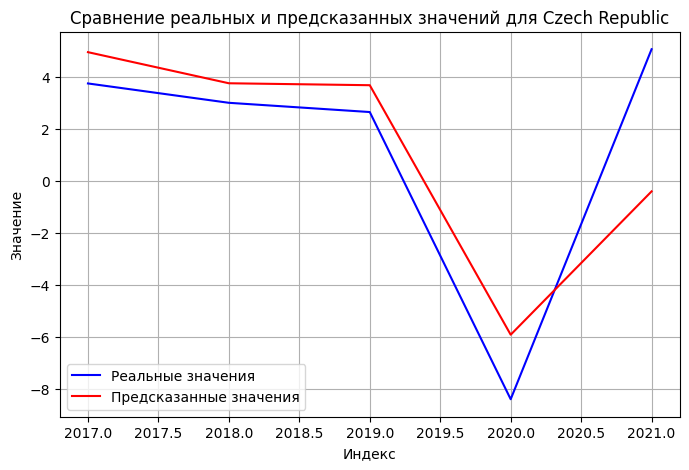

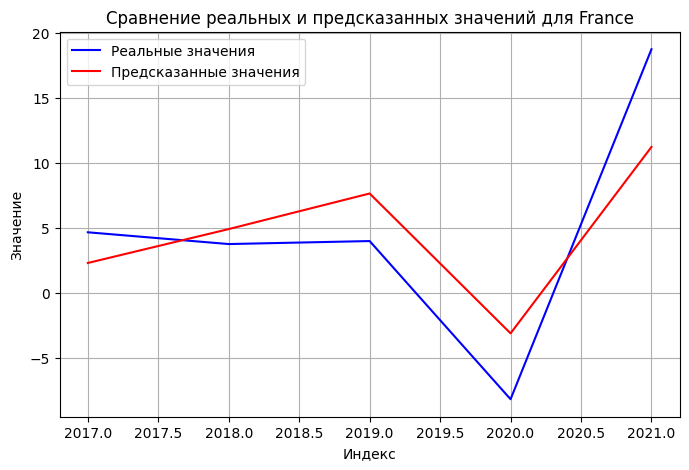

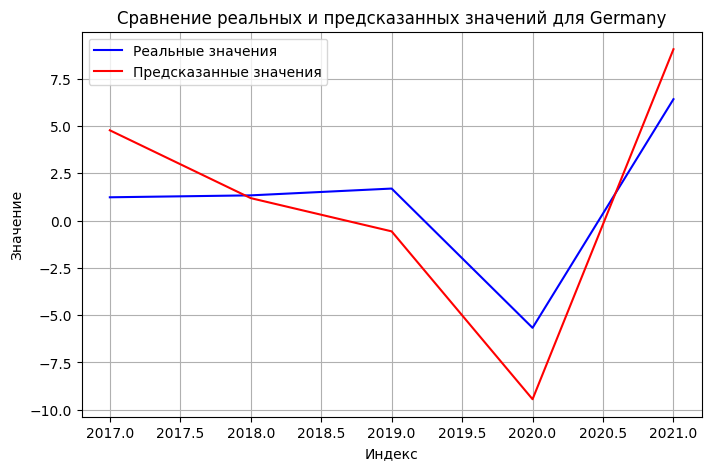

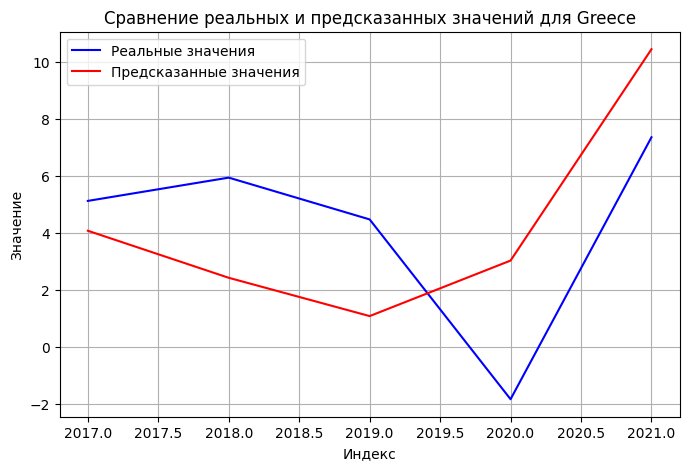

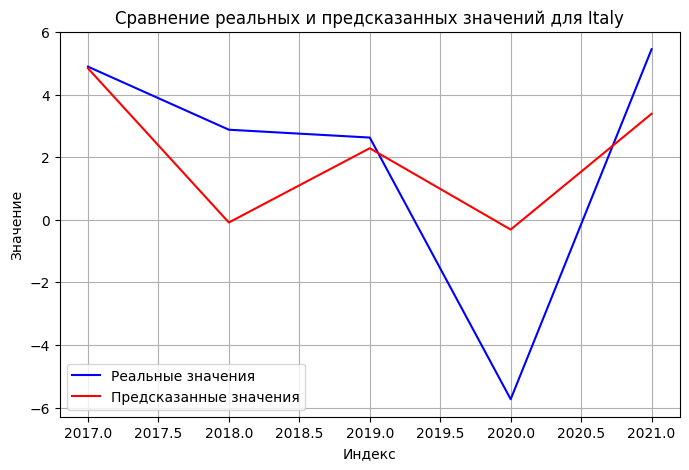

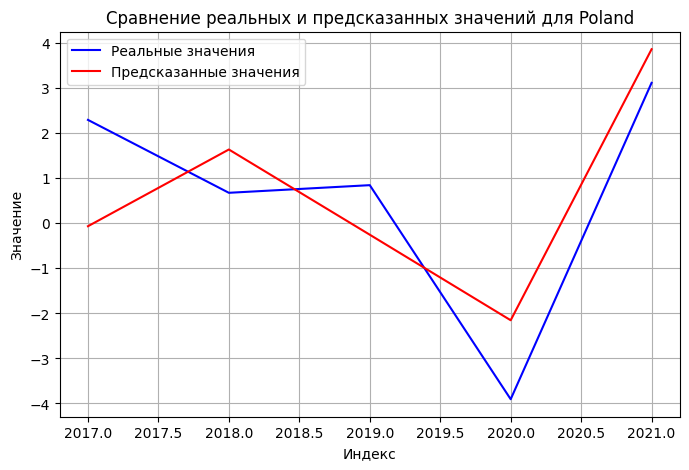

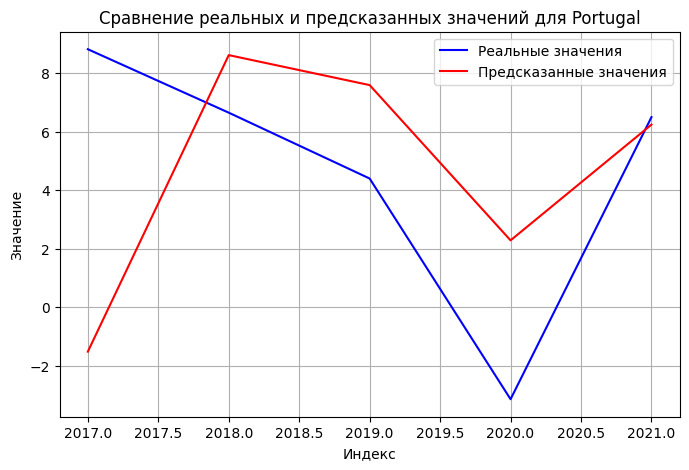

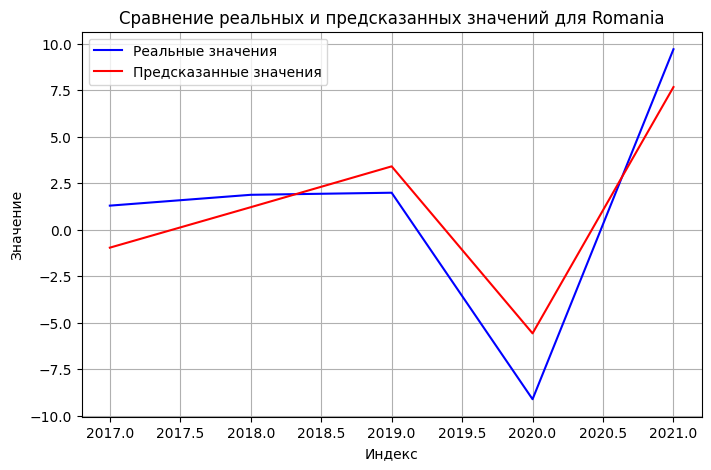

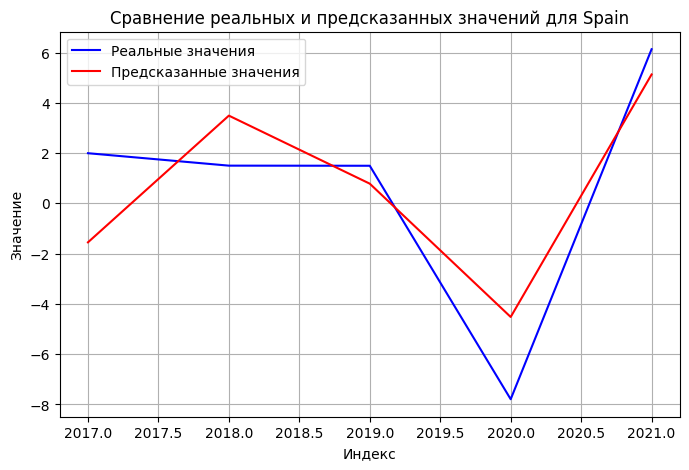

In [ ]:
predicted_values = fixed_model_fitted.predict()
predicted_values_df = pd.DataFrame(predicted_values, index=df_panel_with_dummies.index, columns=['Predicted_GDP'])

for country in df_panel.index.levels[0]:
    real_values = y.loc[country]
    predicted_values_country = predicted_values_df.loc[country]

    plt.figure(figsize=(8, 5))
    plt.plot(real_values.index, real_values.values, label='Реальные значения', color='blue')
    plt.plot(real_values.index, predicted_values_country.values, label='Предсказанные значения', color='red')
    plt.title(f'Сравнение реальных и предсказанных значений для {country}')
    plt.xlabel('Индекс')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.show()

Эта модель предсказывает данные лучше предыдущей.

**Модель со случайными эффектами**

In [ ]:
exog = sm.add_constant(x)
Random_Effects = RandomEffects(dependent=df_panel['Темп роста ВВП на душу населения'], exog=exog)
Random_Effects_fitted = Random_Effects.fit()
print(Random_Effects_fitted)

                               RandomEffects Estimation Summary                               
Dep. Variable:     Темп роста ВВП на душу населения   R-squared:                        0.3767
Estimator:                            RandomEffects   R-squared (Between):              0.3096
No. Observations:                                55   R-squared (Within):               0.3836
Date:                              Wed, Jun 05 2024   R-squared (Overall):              0.3767
Time:                                      13:13:07   Log-likelihood                   -157.31
Cov. Estimator:                          Unadjusted                                           
                                                      F-statistic:                      5.9232
Entities:                                        11   P-value                           0.0002
Avg Obs:                                     5.0000   Distribution:                    F(5,49)
Min Obs:                                     5.000

Константа, Инвестиции в исследования и развитие, Занятость и Уровень образования незначимы (P-value > 0.05).

Проведем отбор признаков, удалим Уровень образования (наибольшее p-значение).

In [ ]:
exog = sm.add_constant(x[['Инвестиции в исследования и развитие', 'Уровень инфляции', 'Занятость', 'Количество иностранных прямых инвестиций (FDI)']])
Random_Effects = RandomEffects(dependent=df_panel['Темп роста ВВП на душу населения'], exog=exog)
Random_Effects_fitted = Random_Effects.fit()
print(Random_Effects_fitted)

                               RandomEffects Estimation Summary                               
Dep. Variable:     Темп роста ВВП на душу населения   R-squared:                        0.3767
Estimator:                            RandomEffects   R-squared (Between):              0.3005
No. Observations:                                55   R-squared (Within):               0.3844
Date:                              Wed, Jun 05 2024   R-squared (Overall):              0.3767
Time:                                      13:15:25   Log-likelihood                   -157.31
Cov. Estimator:                          Unadjusted                                           
                                                      F-statistic:                      7.5531
Entities:                                        11   P-value                           0.0001
Avg Obs:                                     5.0000   Distribution:                    F(4,50)
Min Obs:                                     5.000

Далее удалим константу.

In [ ]:
exog = x[['Инвестиции в исследования и развитие', 'Уровень инфляции', 'Занятость', 'Количество иностранных прямых инвестиций (FDI)']]
Random_Effects = RandomEffects(dependent=df_panel['Темп роста ВВП на душу населения'], exog=exog)
Random_Effects_fitted = Random_Effects.fit()
print(Random_Effects_fitted)

                               RandomEffects Estimation Summary                               
Dep. Variable:     Темп роста ВВП на душу населения   R-squared:                        0.4180
Estimator:                            RandomEffects   R-squared (Between):              0.5662
No. Observations:                                55   R-squared (Within):               0.3817
Date:                              Wed, Jun 05 2024   R-squared (Overall):              0.4180
Time:                                      13:16:20   Log-likelihood                   -158.78
Cov. Estimator:                          Unadjusted                                           
                                                      F-statistic:                      9.1568
Entities:                                        11   P-value                           0.0000
Avg Obs:                                     5.0000   Distribution:                    F(4,51)
Min Obs:                                     5.000

Удалим Инвестиции в исследования и развитие.

In [ ]:
exog = x[['Уровень инфляции', 'Занятость', 'Количество иностранных прямых инвестиций (FDI)']]
Random_Effects = RandomEffects(dependent=df_panel['Темп роста ВВП на душу населения'], exog=exog)
Random_Effects_fitted = Random_Effects.fit()
print(Random_Effects_fitted)

                               RandomEffects Estimation Summary                               
Dep. Variable:     Темп роста ВВП на душу населения   R-squared:                        0.4179
Estimator:                            RandomEffects   R-squared (Between):              0.5674
No. Observations:                                55   R-squared (Within):               0.3813
Date:                              Wed, Jun 05 2024   R-squared (Overall):              0.4179
Time:                                      13:16:46   Log-likelihood                   -158.78
Cov. Estimator:                          Unadjusted                                           
                                                      F-statistic:                      12.446
Entities:                                        11   P-value                           0.0000
Avg Obs:                                     5.0000   Distribution:                    F(3,52)
Min Obs:                                     5.000

Итоговый вид модели:

Y^ = 2.1395 * 'Уровень инфляции' - 0.0560 * 'Занятость' + 0.4724 * 'Количество иностранных прямых инвестиций'

        (0.496)                         (0.022)                 (0.225)

Регрессия в целом значима (P-value для F-распредления < 0.05).

Все коэффициенты R-squared находятся на уровне модели Пула, однако они ниже, чем у модели с фиксированными эффектами.

Сравним реальные данных и прогнозируемые для каждой страны.

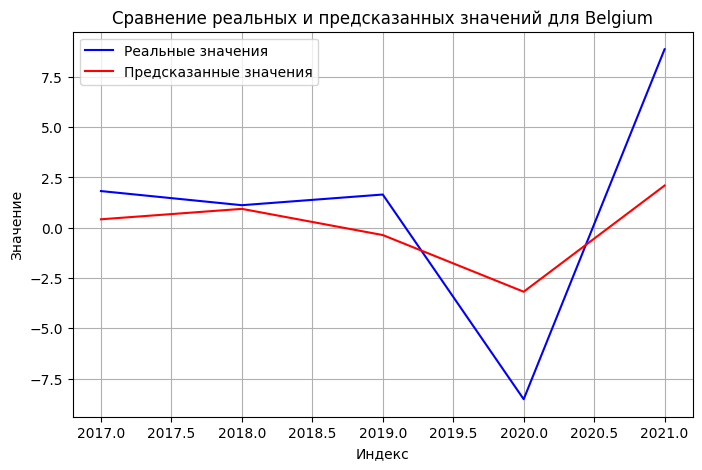

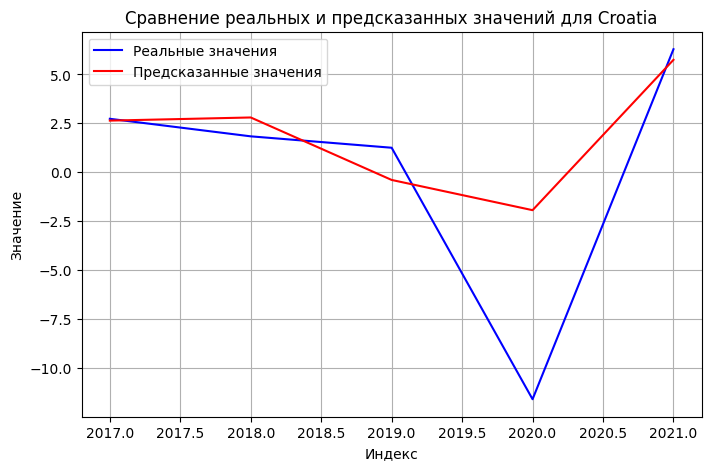

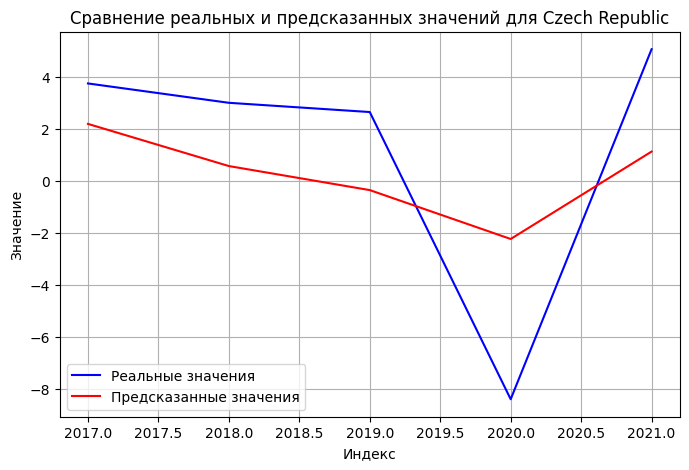

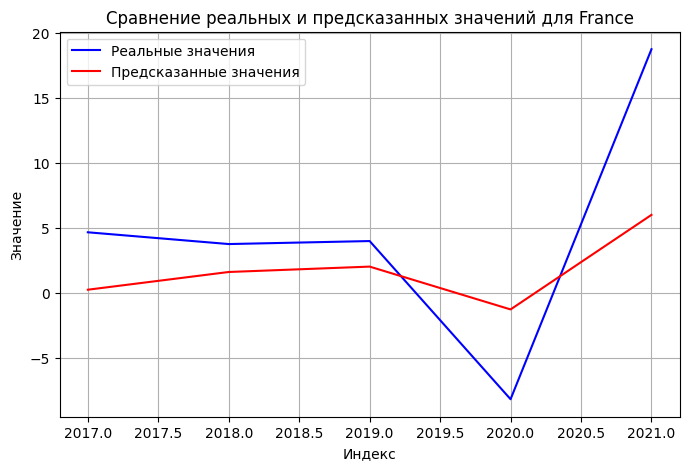

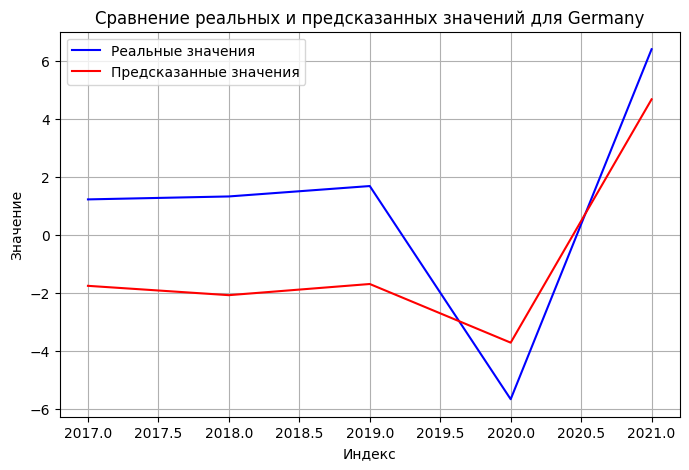

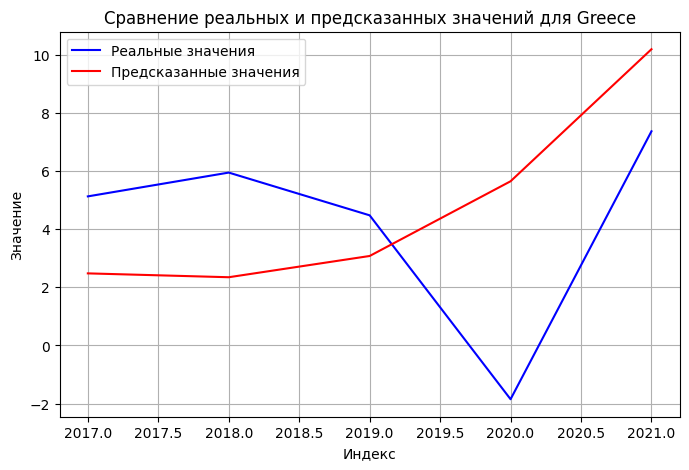

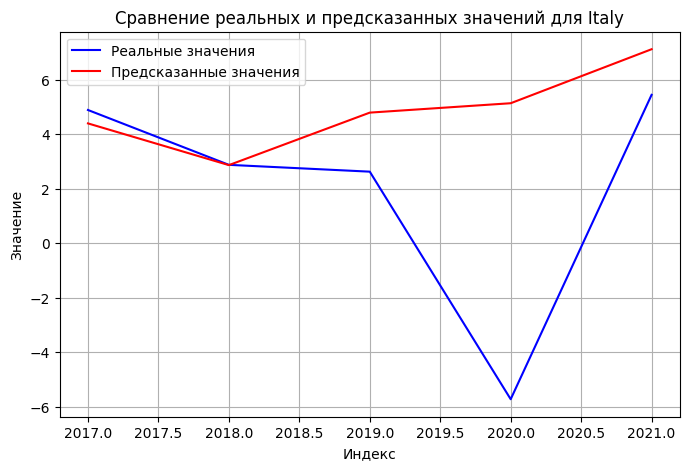

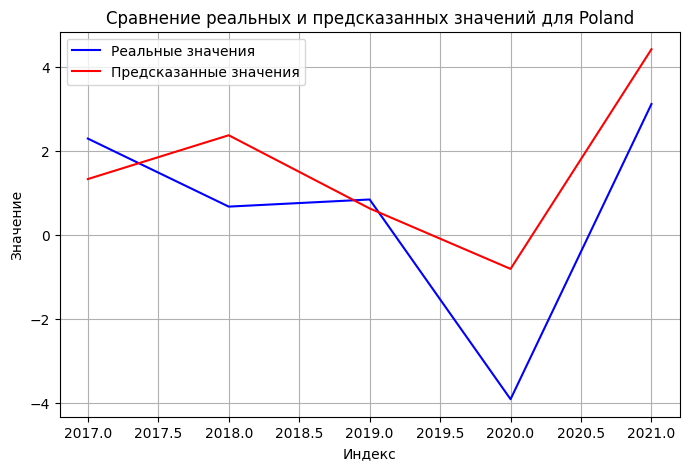

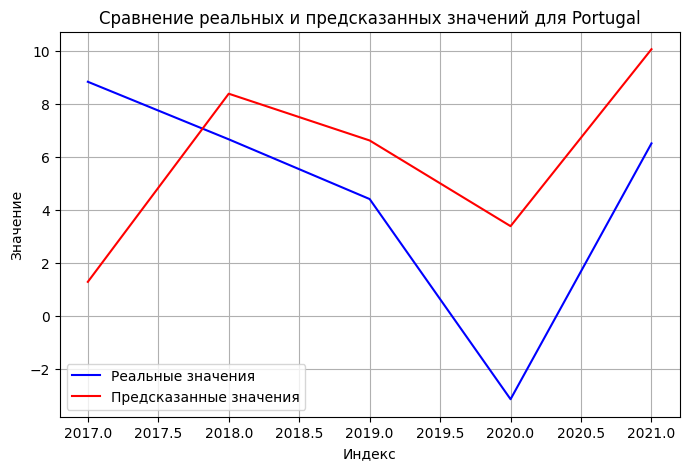

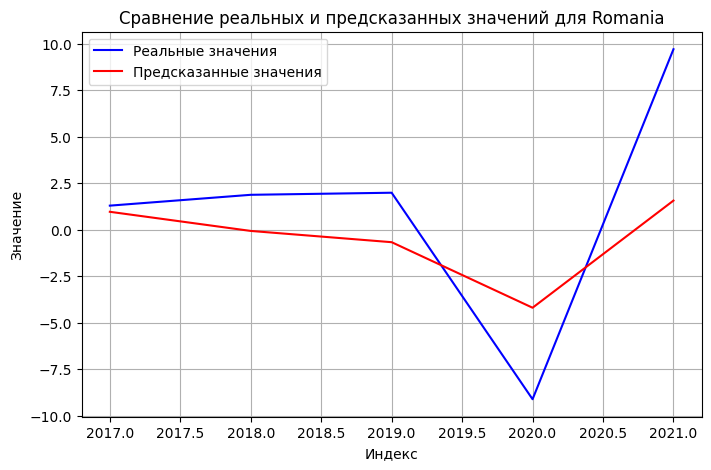

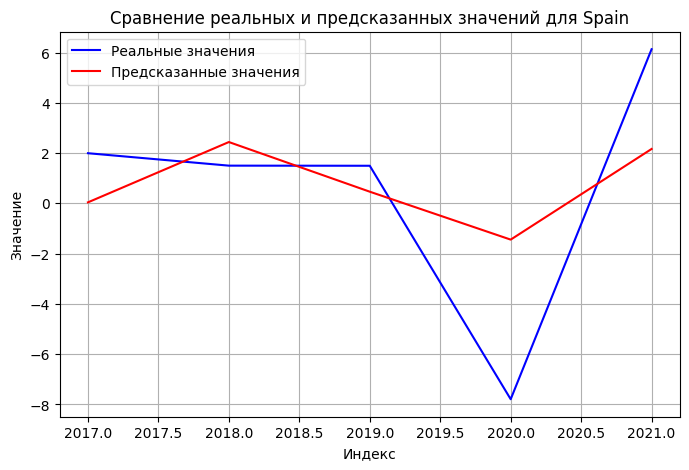

In [ ]:
predicted_values = Random_Effects_fitted.predict()

for country in predicted_values.index.levels[0]:
    real_values = y.loc[country]
    predicted_values_country = predicted_values.loc[country]

    plt.figure(figsize=(8, 5))
    plt.plot(real_values.index, real_values.values, label='Реальные значения', color='blue')
    plt.plot(real_values.index, predicted_values_country.values, label='Предсказанные значения', color='red')
    plt.title(f'Сравнение реальных и предсказанных значений для {country}')
    plt.xlabel('Индекс')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.show()

Модель плохо справляется с предсказанием.

**Результаты**

В результате построения моделей можно установить, что лучшей по качеству оказалась модель с фиксированными эффектами, так как значения коэффициентов детерминации у нее выше, её предсказания лучше, в ней горазно больше переменных.

Сравним реальные данные с смоделированными значениями
трёх построенных ранее моделей на примере Румынии.


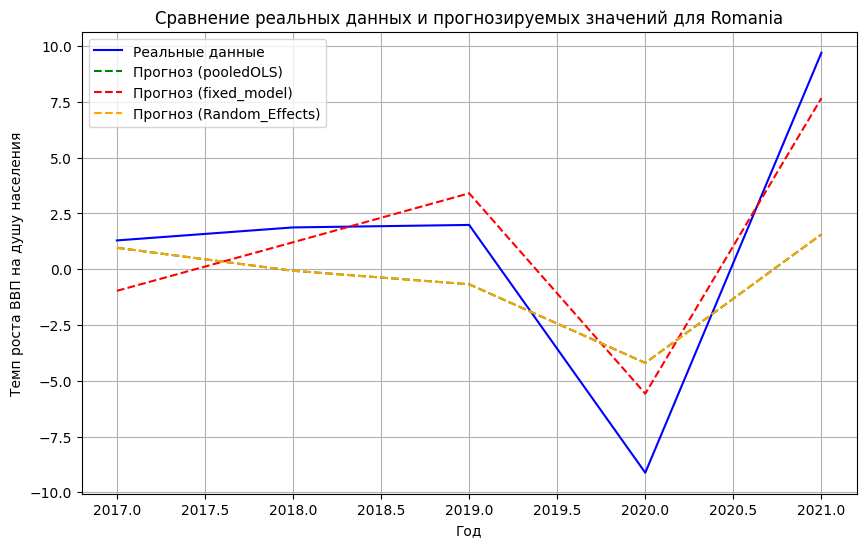

In [ ]:
real_data = df_panel.loc['Romania', 'Темп роста ВВП на душу населения']

predicted_pooledOLS = pooledOLS.predict().loc['Romania']

exog_fixed = sm.add_constant(df_panel_with_dummies.drop(columns=['Темп роста ВВП на душу населения']))
predicted_fixed_model = fixed_model_fitted.predict(exog_fixed).loc['Romania']

predicted_Random_Effects = Random_Effects_fitted.predict().loc['Romania']

plt.figure(figsize=(10, 6))
plt.plot(real_data.index, real_data.values, label='Реальные данные', color='blue')
plt.plot(predicted_pooledOLS.index, predicted_pooledOLS.values, label='Прогноз (pooledOLS)', linestyle='--', color='green')
plt.plot(predicted_fixed_model.index, predicted_fixed_model.values, label='Прогноз (fixed_model)', linestyle='--', color='red')
plt.plot(predicted_Random_Effects.index, predicted_Random_Effects.values, label='Прогноз (Random_Effects)', linestyle='--', color='orange')

plt.title('Сравнение реальных данных и прогнозируемых значений для Romania')
plt.xlabel('Год')
plt.ylabel('Темп роста ВВП на душу населения')
plt.legend()
plt.grid(True)
plt.show()


**Тестирование объединенной модели против модели с фиксированными эффектами**

Для сравнения модели пула с моделью с фиксированными эффектами используется F-критерий.

In [ ]:
from scipy.stats import chi2, f
def pool_vs_fe(pool, fe, alpha=0.05):
    n = pool.nobs
    n_resid = int(fe.summary().tables[0][6][1].data)
    RSS_fe = fe.ssr
    RSS_pool = (pool.resids ** 2).sum()
    F_comp = ((RSS_pool-RSS_fe)/(n-1))/(RSS_fe/n_resid)
    dfn = int(fixed_model_fitted.summary().tables[0][7][1].data)
    dfd = n_resid
    F_crit = f.ppf(1 - alpha, dfn, dfd)
    if F_comp < F_crit:
        print(f'F-значение : {F_comp:.4f} < {F_crit} => модель Pool')
    else:
        print(f'F-значение : {F_comp:.4f} > {F_crit} => модель FE')
pool_vs_fe(pooledOLS, fixed_model_fitted)

F-значение : 0.6286 < 1.9313271108583046 => модель Pool


Поскольку полученное F-значение ниже, чем критическое значение Фишера на уровне a = 0.05, то можно сделать вывод о том, что предпочтительнее является модель пула.


**Тест множителей Лагранжа**

Сравнение модели пула с моделью со случайными эффектами.

In [ ]:
def LM_test(df, pool, alpha=0.05):
    df_pool_resids = pd.concat([df, pool.resids], axis=1)
    df_pool_resids_mean = df_pool_resids.groupby(level=0).mean()
    ssr_grouped_resids_mean = (df_pool_resids_mean['residual']**2).sum()
    ssr_pool_resids = (pool.resids**2).sum()
    n = df_pool_resids_mean.index.size
    T = df.shape[0]/n
    bp_statistic = (n * T)/(2 * (T-1)) * ((T**2 * ssr_grouped_resids_mean)/ssr_pool_resids - 1)**2
    chi2_critical = chi2.ppf((1.0-alpha), 1)
    print(f'Значение статистики : {bp_statistic:.4f}', end = ' ')
    if bp_statistic < chi2_critical:
        print(f'< {chi2_critical:.4f} => модель Pool')
    else:
        print(f'> {chi2_critical:.4f} => модель со случайными эффектами')

LM_test(df_panel, pooledOLS, 0.05)

Значение статистики : 0.4984 < 3.8415 => модель Pool


Тестовая статистика теста LM(1.5003) меньше критического значения chi2 равного 3.8415 при а = 0.05, что означает, что случайный эффект не значим при альфа-значении 0.05 получается, что предпочтительнее является модель Pool.

**Тест Хаусмана**

Для сравнения модели со случайными эффектами с моделью с фиксированными эффектами используется тест Хаусмана.

In [ ]:
def Hausman_test(fe, re, alpha=0.05):
    delta_params = fe.params - re.params[0]
    delta_cov = fe.cov_params() - re.cov.values[0][0]
    hausman_statistic = np.dot(delta_params.T,
    np.linalg.inv(delta_cov)).dot(delta_params)
    df = delta_params.size
    p_value = 1 - chi2.cdf(hausman_statistic, df)
    print(f'Значение статистики : {hausman_statistic:.4f}')
    if p_value < alpha:
        print(f'P-value : {p_value:.4f} < {alpha} => модель с фиксированными эффектами')
    else:
        print(f'P-value : {p_value:.4f} > {alpha} => модель со случайными эффектами')
Hausman_test(fixed_model_fitted, Random_Effects_fitted, 0.05)

Значение статистики : 67.7384
P-value : 0.0000 < 0.05 => модель с фиксированными эффектами


Поскольку полученный P-value < a = 0.05, можно сделать вывод, что предпочтительнее является модель с фиксированными эффектами.

В результате проведенных тестов можно сделать вывод, что модель пула является оптимальным выбором для анализа выбранных панельных данных, что не сходится с результатами анализа ранее. Для прогноза будем использовать модель с фиксированными эффектами, так как она учитывает индивидуальные характеристики, которые постоянны во времени и не изменяются между наблюдениями. Это позволяет более точно оценить влияние переменных на зависимую переменную, учитывая специфические характеристики каждой страны.

**Моделирование**

In [ ]:
dummies = pd.get_dummies(df_panel.index.levels[0], prefix='COUNTRY')
dummies = dummies.reindex(dummies.index.repeat(df_panel.index.levels[1].shape[0]))
dummies.index = df_panel.index

df_panel_with_dummies = pd.concat([df_panel, dummies], axis=1)

for col in dummies.columns:
    df_panel_with_dummies[col] = df_panel_with_dummies[col].astype(int)

exog = sm.add_constant(df_panel_with_dummies.drop(columns=['Темп роста ВВП на душу населения']))
predictions_fixed = fixed_model_fitted.predict(exog)
results_fixed = pd.DataFrame(predictions_fixed, columns=['прогнозирование'], index=df_panel_with_dummies.index)

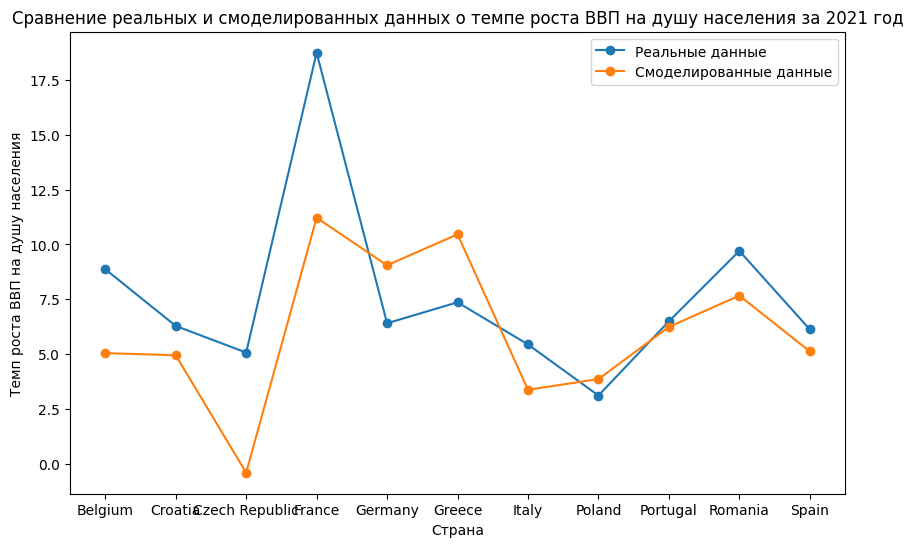

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_panel_with_dummies.loc[df_panel_with_dummies.index.get_level_values(1) == 2021].index.get_level_values(0),
        df_panel_with_dummies.loc[df_panel_with_dummies.index.get_level_values(1) == 2021]['Темп роста ВВП на душу населения'],
        label='Реальные данные', marker='o')

ax.plot(df_panel_with_dummies.loc[df_panel_with_dummies.index.get_level_values(1) == 2021].index.get_level_values(0),
        results_fixed.loc[df_panel_with_dummies.index.get_level_values(1) == 2021]['прогнозирование'],
        label='Смоделированные данные', marker='o')
ax.legend()
ax.set_xlabel('Страна')
ax.set_ylabel('Темп роста ВВП на душу населения')
ax.set_title('Сравнение реальных и смоделированных данных о темпе роста ВВП на душу населения за 2021 год')
plt.show()

Исходя из графика, можно сделать вывод, что предсказания модели в целом соответствуют новым наблюдениям. Это свидетельствует о том, что модель верно описывает данные и способна предсказывать будущие значения с достаточно неплохой точностью.

**Выводы**

В ходе анализа панельных данных были рассмотрены несколько моделей: модель пула, модель с фиксированными эффектами и модель со случайными эффектами. После проведения различных тестов и анализа результатов было выявлено, что модель с фиксированными эффектами демонстрирует наилучшее качество прогнозирования. Это связано с тем, что данная модель учитывает индивидуальные характеристики, которые остаются постоянными во времени.

Хотя модель пула также значима и может быть полезной в некоторых ситуациях, модель с фиксированными эффектами обладает более высокими коэффициентами детерминации, что говорит о ее лучшей способности объяснить вариацию зависимой переменной. Также важно отметить, что модель с фиксированными эффектами превосходит модель со случайными эффектами в качестве прогнозирования, что подтверждает ее предпочтительность для данного набора данных.

Таким образом, для прогнозирования темпа роста ВВП на душу населения наилучшим выбором будет использование модели с фиксированными эффектами.

Самым значимым фактором, влияющим на экономический рост, является уровень инфляции.

Полученные результаты могут служить основой для разработки экономической политики, направленной на стимулирование роста и развитие стран Евросоюза.

